<a href="https://colab.research.google.com/github/AryanSkywalker/AS_P2_Hindi-Character-Detection/blob/main/Project_Emerald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modulation**

In [ ]:
import torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.transforms as Transforms
from torchvision.utils import make_grid
from torchvision import models as Models

import cv2 as cv

import os
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from google.colab.patches import cv2_imshow

# **Dataset Import**

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=a6f05814f1aef06bbe5db666b85f974d9f0740e721167e41ce314f12c404922a
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"arbindjha","key":"e95a50c1fd9fc70fe41d50a05fd23cef"}'}

In [ ]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c padhai-hindi-vow-cons-classification

401 - Unauthorized


In [ ]:
!!unzip /content/padhai-hindi-vow-cons-classification.zip -d /content/Data

['unzip:  cannot find or open /content/padhai-hindi-vow-cons-classification.zip, /content/padhai-hindi-vow-cons-classification.zip.zip or /content/padhai-hindi-vow-cons-classification.zip.ZIP.']

# **Dataset Class**

In [ ]:
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.preTransform = Transforms.Compose([
                                                
                                                Transforms.PILToTensor()

        ])
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.preTransform(image_data).float()
            image_data = self.transform(image_data)

        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping

# **Dataset Processing**

In [ ]:
batchSize = 1024  #@param {type: "slider", min: 1, max: 10000}

In [ ]:
terraTransformer = Transforms.Compose([
    
                                      Transforms.Normalize((0.25, 0.25, 0.25), (0.25, 0.25, 0.25))

])

In [ ]:
datasetPath = os.path.join('Data')
print(datasetPath)

Data


In [ ]:
HindiTrainDataset = VowelConsonantDataset(os.path.join(datasetPath, 'train', 'train'), True, terraTransformer)
HindiTestDataset = VowelConsonantDataset(os.path.join(datasetPath, 'test', 'test'), False, transform=terraTransformer)

In [ ]:
print('Length of Training Set: ', len(HindiTrainDataset))
print('Length of Testing Set: ', len(HindiTestDataset))

Length of Training Set:  10000
Length of Testing Set:  10000


In [ ]:
HindiTrainDataset, HindiValidationDataset = random_split(HindiTrainDataset, [8000, 2000])

In [ ]:
print('Length of Training Set: ', len(HindiTrainDataset))
print('Lenght of Validation Set: ', len(HindiValidationDataset))
print('Length of Testing Set: ', len(HindiTestDataset))

Length of Training Set:  8000
Lenght of Validation Set:  2000
Length of Testing Set:  10000


In [ ]:
trainLoader = DataLoader(HindiTrainDataset, batchSize, True)
validationLoader = DataLoader(HindiValidationDataset, batchSize, False)
testLoader = DataLoader(HindiTestDataset, batchSize, False)

In [ ]:
images, labels = next(iter(trainLoader))
print(images.shape, labels.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:127: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))


torch.Size([1024, 3, 64, 64]) torch.Size([1024, 2, 10])


# **Visualization**

In [ ]:
def DisplayImage(image, title):

  print(title)
  cv2_imshow(image)

In [ ]:
def DisplayBatch(loader):

  images, labels = next(iter(loader))

  grid = make_grid(images).permute(1, 2, 0).numpy()

  DisplayImage(grid, ', '.join(['V:' + str(x[0].item()) + '::C:' + str(x[1].item()) for x in torch.argmax(labels, 2)]))

V:2::C:3, V:2::C:7, V:0::C:0, V:1::C:0, V:3::C:7, V:9::C:8, V:1::C:7, V:9::C:1, V:2::C:0, V:1::C:5, V:7::C:7, V:6::C:9, V:2::C:8, V:7::C:5, V:7::C:0, V:5::C:2, V:3::C:1, V:5::C:5, V:4::C:9, V:5::C:0, V:1::C:4, V:6::C:6, V:1::C:7, V:4::C:7, V:5::C:6, V:2::C:9, V:8::C:0, V:0::C:7, V:6::C:9, V:5::C:0, V:2::C:9, V:0::C:7


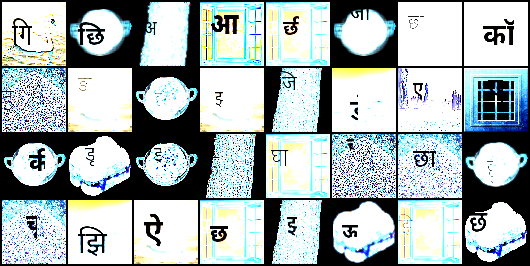

In [ ]:
DisplayBatch(trainLoader)

# **Neural Network**

In [ ]:
class FoxNet(nn.Module):

    def __init__(self):

        super(FoxNet, self).__init__()

        self.sa = nn.Sequential(
            
                                nn.Linear(4096, 2048),
                                nn.ReLU(),
                                nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 512),
                                nn.ReLU(),
                                nn.Linear(512, 256),
                                nn.ReLU()

        )

        self.ca = nn.Sequential(
            
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Linear(32, 10)

        )

        self.ra = nn.Sequential(
            
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, 64),
                                nn.ReLU(),
                                nn.Linear(64, 32),
                                nn.ReLU(),
                                nn.Linear(32, 10)

        )

    def forward(self, x):

        flatX = x.view(x.shape[0], -1)

        feedX = self.sa(flatX)

        vowelsYh = self.ca(feedX)
        consonantsYh = self.ra(feedX)

        return vowelsYh, consonantsYh

    def Learn(self, data, epochs, lossFunc, optimizer, modelArchive, valData):

        lossArchive = []
        accuracyArchive = []
        loss = None
        minimumLoss = 10 ** 10

        for epoch in tqdm_notebook(range(epochs), total=len(range(epochs)), unit='Epochs per Second'):

            print('\n\n\nEpoch Iteration: ', epoch + 1)

            for images, labels in data:

                outputsV, outputsC = self.forward(images.float())
                labelsV = torch.argmax(labels[:, 0, :], 1)
                labelsC = torch.argmax(labels[:, 1, :], 1)

                lossV = lossFunc(outputsV, labelsV)
                lossC = lossFunc(outputsC, labelsC)

                lossV.backward()

                #print(lossV, lossC, type(lossV), type(lossC))
                
                #commonLoss = lossV + lossC
                #commonLoss.backward()

                optimizer.step()
                optimizer.zero_grad()

            #lossArchive.append(commonLoss.item())
            lossArchive.append(lossV.item())
            accuracyArchive.append(self.Accurize(valData))

            """if commonLoss.item() <= minimumLoss:

              torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
              minimumLoss = commonLoss.item()
              minLossEpoch = epoch"""

            if lossV.item() <= minimumLoss:

              torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
              minimumLoss = lossV.item()
              minLossEpoch = epoch

            modelName = 'model_' + str(epoch + 1) + '.pth'

            torch.save(self.state_dict(), os.path.join(modelArchive, modelName))

            print('Loss After Epoch ', epoch + 1, ': \t', lossV.item(), 'Validation Accuracy: ', self.Accurize(valData))

            if  keyboard.is_pressed('a'):

              print('Manual Abort...')
              break


        plt.plot(lossArchive)
        print('Final Loss: ', lossV.item(), 'Final Loss Validation Accuracy: ', accuracyArchive[-1])
        print('\nMinimum Loss: ', minimumLoss, 'Minimum Loss Validation Accuracy: ', accuracyArchive[minLossEpoch])

        bestEpoch = accuracyArchive.index(max(accuracyArchive))
      
        print('\nBest Loss: ', lossArchive[bestEpoch], 'Best Loss Validation Accuracy: ', max(accuracyArchive))

        bestModelName = os.path.join(modelArchive, 'model_' + str(bestEpoch + 1) + '.pth')
        self.load_state_dict(torch.load(bestModelName))

        plt.savefig('Models/Loss Visualization.png')
        plt.show()

    def Accurize(self, valLoader):

        total, correctV, correctC = 0, 0, 0

        for images, labels in tqdm_notebook(valLoader, total=len(valLoader), unit='Batch per Second'):

            predictionsV, predictionsC = self.forward(images.float())

            t, binarisedPredictionsV = torch.max(predictionsV, 1)
            t, binarisedPredictionsC = torch.max(predictionsC, 1)
            
            binarisedLabelsV = torch.argmax(labels[:, 0, :], 1)
            binarisedLabelsC = torch.argmax(labels[:, 1, :], 1)

            total += images.shape[0]

            correctV += (binarisedLabelsV == binarisedPredictionsV).sum().item()
            correctC += (binarisedLabelsC == binarisedPredictionsC).sum().item()

        return correctV / total * 100, correctC / total * 100

    def Predict(self, X):

        yHV, yHC = self.forward(X.float())
        yH = torch.stack((yHV, yHC), 1)
        t, predictions = torch.max(yH, 2)


        return predictions

# **Learning**

In [ ]:
foxNet = FoxNet()

In [ ]:
learningRate = 0.0001
lossFunction = nn.CrossEntropyLoss()

In [ ]:
Optimizer = optim.SGD(foxNet.parameters(), learningRate, momentum=0.07)

<ipython-input-20-3ae06cb318f2>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=len(range(epochs)), unit='Epochs per Second'):





Epoch Iteration:  1


<ipython-input-20-3ae06cb318f2>:131: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, labels in tqdm_notebook(valLoader, total=len(valLoader), unit='Batch per Second'):



Loss After Epoch  1 : 	 2.3355307579040527 Validation Accuracy:  (10.65, 10.05)



Epoch Iteration:  2



Loss After Epoch  2 : 	 2.333082914352417 Validation Accuracy:  (10.65, 10.05)



Epoch Iteration:  3



Loss After Epoch  3 : 	 2.356759548187256 Validation Accuracy:  (10.65, 10.05)



Epoch Iteration:  4



Loss After Epoch  4 : 	 2.3393096923828125 Validation Accuracy:  (10.65, 10.05)



Epoch Iteration:  5



Loss After Epoch  5 : 	 2.353422164916992 Validation Accuracy:  (10.65, 10.05)

Final Loss:  2.353422164916992 Final Loss Validation Accuracy:  (10.65, 10.05)

Minimum Loss:  2.333082914352417 Minimum Loss Validation Accuracy:  (10.65, 10.05)

Best Loss:  2.3355307579040527 Best Loss Validation Accuracy:  (10.65, 10.05)


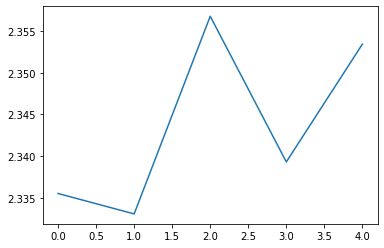

In [ ]:
foxNet.Learn(trainLoader, 5, lossFunction, Optimizer, os.path.join('.', 'Models'), validationLoader)

# **Test**

In [ ]:
class DustNet(nn.Module):

    def __init__(self):

        super(DustNet, self).__init__()

        self.FeedForward = nn.Sequential(

                                        nn.Linear(4096, 1024),
                                        nn.Sigmoid(),
                                        nn.Linear(1024, 1024),
                                        nn.Sigmoid(),
                                        nn.Linear(1024, 1024),
                                        nn.Sigmoid(),
                                        nn.Linear(1024, 1024),
                                        nn.Sigmoid(),
                                        nn.Linear(1024, 10)

        )

    def forward(self, x):

        flatX = x.view(x.shape[0], -1)
        feedX = self.FeedForward(flatX)

        return feedX

    def Learn(self, data, epochs, lossFunc, optimizer, modelArchive, valData):

        lossArchive = []
        accuracyArchive = []
        loss = None
        minimumLoss = 10 ** 10

        for epoch in range(epochs):

            print('\n\n\nEpoch Iteration: ', epoch + 1)
            i = 0

            for images, labels in data:

                i += 1
                labels = labels[:, 0, :]
                binarisedLabels = torch.argmax(labels, 1)

                outputs = self.forward(images.float())

                loss = lossFunc(outputs, binarisedLabels)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            lossArchive.append(loss.item())
            accuracyArchive.append(self.Accurize(trainLoader))

            if loss.item() <= minimumLoss:

              torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
              minimumLoss = loss.item()
              minLossEpoch = epoch

            modelName = 'model_' + str(epoch + 1) + '.pth'

            torch.save(self.state_dict(), os.path.join(modelArchive, modelName))

            print('Loss After Epoch ', epoch + 1, ': \t', loss.item(), 'Validation Accuracy: ', self.Accurize(trainLoader))

            if  keyboard.is_pressed('a'):

              print('Manual Abort...')
              break


        plt.plot(lossArchive)
        print('Final Loss: ', loss.item(), 'Final Loss Validation Accuracy: ', accuracyArchive[-1])
        print('\nMinimum Loss: ', minimumLoss, 'Minimum Loss Validation Accuracy: ', accuracyArchive[minLossEpoch])

        bestEpoch = accuracyArchive.index(max(accuracyArchive))
      
        print('\nBest Loss: ', lossArchive[bestEpoch], 'Best Loss Validation Accuracy: ', max(accuracyArchive))

        bestModelName = os.path.join(modelArchive, 'model_' + str(bestEpoch + 1) + '.pth')
        self.load_state_dict(torch.load(bestModelName))

        plt.savefig('Models/Loss Visualization.png')
        plt.show()

    def Accurize(self, valLoader):

        total, correct = 0, 0

        for images, labels in valLoader:

            labels = labels[:, 0, :]
            binarisedLabels = torch.argmax(labels, 1)

            predictions = self.forward(images.float())

            t, binarizedPredictions = torch.max(predictions, 1)

            total += images.shape[0]
            correct += (binarisedLabels == binarizedPredictions).sum().item()

        return correct / total * 100

    def Predict(self, X):

        yH = self.forward(X)
        t, predictions = torch.max(yH, 1)

        return predictions

In [ ]:
Polly = DustNet()

In [ ]:
lossFunction = nn.CrossEntropyLoss()

In [ ]:
learningRate, momentum = 0.05, 0.05

In [ ]:
Optimizer = optim.SGD(Polly.parameters(), learningRate, momentum)

In [ ]:
Polly.Learn(trainLoader, 15, lossFunction, Optimizer, os.path.join('.', 'Mdodels'), validationLoader)

# **Ultimum Telum**

In [ ]:
accelerator = torch.device('cuda')

In [ ]:
images, labels = next(iter(trainLoader))

In [ ]:
pixelCount = len(aquaTrainDataset) * 64 * 64

In [ ]:
totalR, totalG, totalB = 0, 0, 0

for images, labels in trainLoader: 
  
  totalR += images[0, :, :].sum()
  totalG += images[1, :, :].sum()
  totalB += images[2, :, :].sum()

meanR, meanG, meanB = totalR / pixelCount, totalG / pixelCount, totalB / pixelCount

In [ ]:
squaredErrorR, squaredErrorG, squaredErrorB = 0, 0, 0

for images, labels in trainLoader:

  squaredErrorR += ((images[0, :, :] - meanR).pow(2)).sum()
  squaredErrorG += ((images[1, :, :] - meanG).pow(2)).sum()
  squaredErrorB += ((images[2, :, :] - meanB).pow(2)).sum()

stdR, stdG, stdB = torch.sqrt(squaredErrorR / pixelCount), torch.sqrt(squaredErrorG / pixelCount), torch.sqrt(squaredErrorB / pixelCount)

In [ ]:
meanR, meanG, meanB, stdR, stdG, stdB

(tensor(1.1300),
 tensor(1.0904),
 tensor(0.9888),
 tensor(23.4888),
 tensor(20.2357),
 tensor(24.1155))

In [ ]:
aquaTransformer = Transforms.Compose([
    
                                    Transforms.Normalize((-0.1128, -0.1115, -0.1137), (0.3465, 0.3425, 0.3419))
                                    
])

In [ ]:
aquaTrainDataset = VowelConsonantDataset(os.path.join(datasetPath, 'train', 'train'), True, aquaTransformer)
aquaTestDataset = VowelConsonantDataset(os.path.join(datasetPath, 'test', 'test'), False, aquaTransformer)

In [ ]:
aquaTrainDataset, aquaValidationDataset = torch.utils.data.random_split(aquaTrainDataset, [8000, 2000])

In [ ]:
print('Length of Train Dataset: ', len(aquaTrainDataset))
print('Length of Validation Dataset: ', len(aquaValidationDataset))
print('Length of Test Dataset: ', len(aquaTestDataset))

Length of Train Dataset:  8000
Length of Validation Dataset:  2000
Length of Test Dataset:  10000


In [ ]:
trainLoader = DataLoader(aquaTrainDataset, batchSize, True)
validationLoader = DataLoader(aquaValidationDataset, batchSize, False)
testLoader = DataLoader(aquaTestDataset, batchSize, False)

In [ ]:
images, labels = next(iter(trainLoader))
print(images.shape, labels.shape)

torch.Size([1024, 3, 64, 64]) torch.Size([1024, 2, 10])


# **Visualization**

In [ ]:
def ShowColoredBatch(loader):

  images, labels = next(iter(loader))

  grid = make_grid(images).permute(1, 2, 0).numpy()

  DisplayImage(grid, ', '.join(['V:' + str(x[0].item()) + '::C:' + str(x[1].item()) for x in torch.argmax(labels, 2)]))

V:1::C:0, V:1::C:4, V:4::C:3, V:9::C:6, V:3::C:9, V:7::C:2, V:4::C:0, V:9::C:5, V:1::C:0, V:5::C:0, V:0::C:3, V:0::C:8, V:1::C:2, V:6::C:4, V:2::C:0, V:7::C:3, V:8::C:1, V:1::C:5, V:2::C:7, V:7::C:4, V:1::C:7, V:7::C:7, V:4::C:4, V:2::C:9, V:6::C:2, V:7::C:5, V:5::C:0, V:8::C:2, V:9::C:0, V:4::C:7, V:4::C:8, V:0::C:9


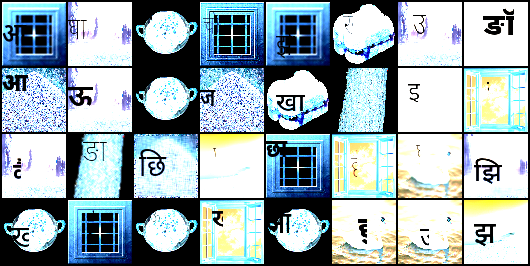

In [ ]:
ShowColoredBatch(trainLoader)

In [ ]:
cv.destroyAllWindows()

# **Arboron**

In [ ]:
class Arboron(nn.Module):

  def __init__(self):

    super(Arboron, self).__init__()

    self.Arbor = nn.Sequential(
        
                              nn.Conv2d(3, 16, 7),
                              nn.ReLU(),
                              nn.Conv2d(16, 64, 7),
                              nn.ReLU(),
                              nn.AvgPool2d(3, 2),
                              nn.Conv2d(64, 64, 7),
                              nn.ReLU(),
                              nn.AvgPool2d(4, 2)

    )

    self.Sirese = nn.Sequential(
        
                              nn.Linear(4096, 4096),
                              nn.ReLU(),
                              nn.Linear(4096, 2048),
                              nn.ReLU(),
                              nn.Linear(2048, 10)

    )

    self.Fifere = nn.Sequential(
        
                              nn.Linear(4096, 4096),
                              nn.ReLU(),
                              nn.Linear(4096, 2048),
                              nn.ReLU(),
                              nn.Linear(2048, 10)

    )

  def forward(self, x):

    #print('Raw X Shape: ', x.shape)
    convolutedX = self.Arbor(x)
    #print('Convoluted X Shape: ', convolutedX.shape)
    flatX = convolutedX.view(convolutedX.shape[0], -1)
    #print('Flat X Shape: ', flatX.shape)
    yPrimeVowels = self.Sirese(flatX)
    yPrimeConsonants = self.Fifere(flatX)
    #print('Prime Shapes: ', yPrimeVowels.shape, yPrimeConsonants.shape)
    yH = torch.stack((yPrimeVowels, yPrimeConsonants), 1)
    #print('yH Shape: ', yH.shape)

    return yPrimeVowels, yPrimeConsonants
  
  def Learn(self, data, epochs, lossFunc, optimizer, modelArchive, valData):

    lossArchive = []
    trainAccuracyArchive, valAccuracyArchive = [], []
    loss = None
    minimumLoss = 10 ** 10

    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='Epochs/Second'):

        print('\n\n\nEpoch Iteration: ', epoch + 1)
        i = 0

        for images, labels in data:

            images, labels = images.to(accelerator), labels.to(accelerator)
            labelsV, labelsC = torch.argmax(labels[:, 0, :], 1), torch.argmax(labels[:, 1, :], 1)

            i += 1

            #print('Batch Iteration Index: ', i)
            binarisedLabels = torch.argmax(labels[:, 0, :], 1)

            outputsV, outputsC = self.forward(images.float())

            lossV = lossFunc(outputsV, labelsV)
            lossC = lossFunc(outputsC, labelsC)
          
            commonLoss = lossV + lossC
            commonLoss.backward(retain_graph=True)

            optimizer.step()
            optimizer.zero_grad()

        valAccuracy = self.Accurize(valData)
        trainAccuracy = self.Accurize(trainLoader)

        lossArchive.append(commonLoss.item())
        trainAccuracyArchive.append(trainAccuracy)
        valAccuracyArchive.append(valAccuracy)


        if commonLoss.item() <= minimumLoss:

          torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
          minimumLoss = commonLoss.item()
          minLossEpoch = epoch

        modelName = 'model_' + str(epoch + 1) + '.pth'

        torch.save(self.state_dict(), os.path.join(modelArchive, modelName))

        print('Loss After Epoch ', epoch + 1, ': \t', commonLoss.item(), 'Validation Accuracy: ', valAccuracy, trainAccuracy)

        """if  keyboard.is_pressed('a'):

          print('Manual Abort...')
          break"""


    plt.plot(lossArchive)
    print('Final Loss: ', commonLoss.item(), 'Final Loss Validation Accuracy: ', valAccuracyArchive[-1], trainAccuracyArchive[-1])
    print('\nMinimum Loss: ', minimumLoss, 'Minimum Loss Validation Accuracy: ', valAccuracyArchive[minLossEpoch], trainAccuracyArchive[minLossEpoch])

    bestEpoch = valAccuracyArchive.index(max(valAccuracyArchive))

    print('\nBest Loss: ', lossArchive[bestEpoch], 'Best Loss Validation Accuracy: ', max(valAccuracyArchive), max(trainAccuracyArchive))

    bestModelName = os.path.join(modelArchive, 'model_' + str(bestEpoch + 1) + '.pth')
    self.load_state_dict(torch.load(bestModelName))

    plt.savefig('Models/Loss Visualization.png')
    plt.show()

  def Accurize(self, valLoader):

    total, correctV, correctC = 0, 0, 0

    for images, labels in tqdm_notebook(valLoader, total=len(valLoader), unit='Batches/Second'):

        images, labels = images.to(accelerator), labels.to(accelerator)

        predictionsV, predictionsC = self.forward(images.float())
        predictionsV, predictionsC = torch.argmax(predictionsV, 1), torch.argmax(predictionsC, 1)
        
        binarisedLabelsV, binarisedLabelsC = torch.argmax(labels[:, 0, :], 1), torch.argmax(labels[:, 1, :], 1)

        total += images.shape[0]
        correctV += (binarisedLabelsV == predictionsV).sum().item()
        correctC += (binarisedLabelsC == predictionsC).sum().item()

    return correctV / total * 100, correctC / total * 100

  def Predict(self, X):

    X = X.to(accelerator)

    yHV, yHC = self.forward(X.float())
    predictionsV, predictionsC = torch.argmax(yHV, 1), torch.argmax(yHC, 1)

    return predictionsV, predictionsC


In [ ]:
arboron = Arboron()

In [ ]:
arboron.to(accelerator)

Arboron(
  (Arbor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 64, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=3, stride=2, padding=0)
    (5): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (6): ReLU()
    (7): AvgPool2d(kernel_size=4, stride=2, padding=0)
  )
  (Sirese): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=10, bias=True)
  )
  (Fifere): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [ ]:
learningRate, momentum = 0.001, 0.00001
epochs = 50

lossFunction = nn.CrossEntropyLoss()

In [ ]:
Optimizer = optim.SGD(arboron.parameters(), learningRate)

In [ ]:
arboron.Learn(trainLoader, epochs, lossFunction, Optimizer, os.path.join('.', 'Models'), validationLoader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`





Epoch Iteration:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Loss After Epoch  1 : 	 4.589576244354248 Validation Accuracy:  (12.9, 11.65) (13.525, 12.0375)



Epoch Iteration:  2



Loss After Epoch  2 : 	 4.575438499450684 Validation Accuracy:  (12.950000000000001, 11.75) (13.9375, 12.0875)



Epoch Iteration:  3



Loss After Epoch  3 : 	 4.574659824371338 Validation Accuracy:  (13.350000000000001, 11.799999999999999) (14.5875, 12.2125)



Epoch Iteration:  4



Loss After Epoch  4 : 	 4.562382221221924 Validation Accuracy:  (13.100000000000001, 12.45) (15.45, 12.0625)



Epoch Iteration:  5



Loss After Epoch  5 : 	 4.565101623535156 Validation Accuracy:  (13.950000000000001, 11.899999999999999) (16.275000000000002, 12.2125)



Epoch Iteration:  6



Loss After Epoch  6 : 	 4.54570198059082 Validation Accuracy:  (13.55, 12.15) (15.825, 12.3)



Epoch Iteration:  7



Loss After Epoch  7 : 	 4.539962291717529 Validation Accuracy:  (14.05, 12.45) (16.325, 12.687499999999998)



Epoch Iteration:  8



Loss After Epoch  8 : 	 4.537386894226074 Validation Accuracy:  (13.600000000000001, 13.0) (16.6125, 13.4375)



Epoch Iteration:  9



Loss After Epoch  9 : 	 4.540299892425537 Validation Accuracy:  (14.05, 12.65) (17.1, 13.475000000000001)



Epoch Iteration:  10



Loss After Epoch  10 : 	 4.522030830383301 Validation Accuracy:  (14.6, 12.950000000000001) (16.7625, 13.362499999999999)



Epoch Iteration:  11



Loss After Epoch  11 : 	 4.509692192077637 Validation Accuracy:  (15.15, 12.8) (17.837500000000002, 13.9125)



Epoch Iteration:  12



Loss After Epoch  12 : 	 4.497735023498535 Validation Accuracy:  (15.75, 13.200000000000001) (17.8125, 13.850000000000001)



Epoch Iteration:  13



Loss After Epoch  13 : 	 4.502532958984375 Validation Accuracy:  (15.049999999999999, 12.0) (18.0375, 13.625000000000002)



Epoch Iteration:  14


In [ ]:
arboron.load_state_dict(torch.load(os.path.join('.', 'Electrica Models', 'model_36.pth')))

<All keys matched successfully>

In [ ]:
arboron.Accurize(trainLoader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


(88.125, 83.85000000000001)

In [ ]:
def veritasAccurize(loader, model):

  correct, total = 0, 0

  for images, labels in loader:

    images, labels = images.to(accelerator).float(), labels.to(accelerator)

    predictionsV, predictionsC = model(images)
    binarisedPredictionsV, binarisedPredictionsC = torch.argmax(predictionsV, 1), torch.argmax(predictionsC, 1)
    binarisedLabels = torch.argmax(labels, 2)
    labelsV, labelsC = binarisedLabels[:, 0], binarisedLabels[:, 1]

    total += labels.shape[0]
    
    for i in range(labels.shape[0]):

      if labelsV[i].item() == binarisedPredictionsV[i].item() and labelsC[i].item() == binarisedPredictionsC[i].item():

        correct += 1

  return correct / total * 100


In [ ]:
veritasAccurize(validationLoader, arboron)

80.05

# **The Order Of The Ancients**